* This notebook is to investigate why mixing region sho up in the near field and north of the river mouth at low tides rather than high tides.

In [1]:
import numpy as np
import netCDF4 as nc
from salishsea_tools import (
    nc_tools,
    viz_tools,
    tidetools,
    stormtools
)
import datetime, os
from glob import glob
from IPython.core.display import Image,display
from nowcast import figures
import matplotlib.pyplot as plt
import matplotlib as mpl
import pytz
import R_mixStuff as RS
mpl.rcParams.update({'font.size': 24})
mpl.rcParams["axes.formatter.useoffset"] = False
%matplotlib inline

In [2]:
sites = {
    'Sandheads': {'lat': 49.10,'lon': -123.30,'j' : 46,'i' : 53},
    'Steveston':{
        'j': 48, ##428
        'i': 52, ##292
    },
    'VENUS East':{'lat': 49.0419, 'lon': -123.3176,'depth': 170, 'j': 36, 'i': 43},    
    'VENUS Central':{ 'lat': 49.0401,'lon': -123.4261, 'depth': 300, 'j': 44, 'i': 26 },
    'Point on transect':{'j':36,'i':20},
    'mouth':{ 'j':39,'i':74},
    'near field':{'j':43,'i':64},
    'estuary':{'j':36,'i':102},
    }

In [3]:
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
X = grid6.variables['nav_lon'][:, :]
Y = grid6.variables['nav_lat'][:, :]
bathy = grid6.variables['Bathymetry'][:, :]

* Load all simulation results

In [4]:
river_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014OnlyRiver/oct2014onlyriver_T.nc')
river_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014OnlyRiver/oct2014onlyriver_U.nc')
river_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014OnlyRiver/oct2014onlyriver_V.nc')
notide_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014notides/oct2014notides_T.nc')
notide_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014notides/oct2014notides_U.nc')
notide_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014notides/oct2014notides_V.nc')
nowind_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nowind/oct2014nowind_T.nc')
nowind_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nowind/oct2014nowind_U.nc')
nowind_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nowind/oct2014nowind_V.nc')
nof_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nof/oct2014nof_T.nc')
nof_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nof/oct2014nof_U.nc')
nof_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nof/oct2014nof_V.nc')
all_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_T.nc')
all_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_U.nc')
all_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_V.nc')

In [5]:
## tmask
mesh = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/mesh_mask.nc')
tmask = mesh.variables['tmask'][0,:,380:510,240:397]
np_mask = np.abs(1-tmask) 

# Tidal heights

In [6]:
## load t_tide
tfile = '/ocean/jieliu/research/meopar/tools/SalishSeaNowcast/\
tidal_predictions/Point Atkinson_t_tide_compare8_31-Dec-2013_02-Dec-2015.csv'
ttide, msl = stormtools.load_tidal_predictions(tfile)

In [7]:
def find_ind_tide(run_low, run_up, run_label1,run_label2):
    """To find index of ttide within a time range"""
    run_low = run_low.replace(tzinfo=pytz.utc) ## convert model datetime to tzinfo=<UTC>
    run_up = run_up.replace(tzinfo=pytz.utc) ## the time i want to label on the plot
    run_label1 = run_label1.replace(tzinfo=pytz.utc)
    run_label2 = run_label2.replace(tzinfo=pytz.utc)
    ttide_dt  = ttide.time.dt.to_pydatetime() ## convert ttide.time (pandas) to datetime
    for i in range(len(ttide_dt)):
        if ttide_dt[i]== run_low:
            low_ind = i
        if ttide_dt[i]== run_up:
            up_ind = i  
        if ttide_dt[i]== run_label1:
            lab_ind1 = i  
        if ttide_dt[i]== run_label2:
            lab_ind2 = i  
    return low_ind, up_ind, lab_ind1,lab_ind2

In [8]:
## select the time slot to make comparison
strings = {'specific time': {'t_ind_high': -4,'t_ind_low':-12,'middle of flood':-8},
              'ave':{'t_ind_high':-1,'t_ind_low':-1}}

In [9]:
## define dates
sd = datetime.datetime(2014,10,1,0,30,tzinfo=pytz.utc)
ed = datetime.datetime(2014,10,31,23,30,tzinfo=pytz.utc)

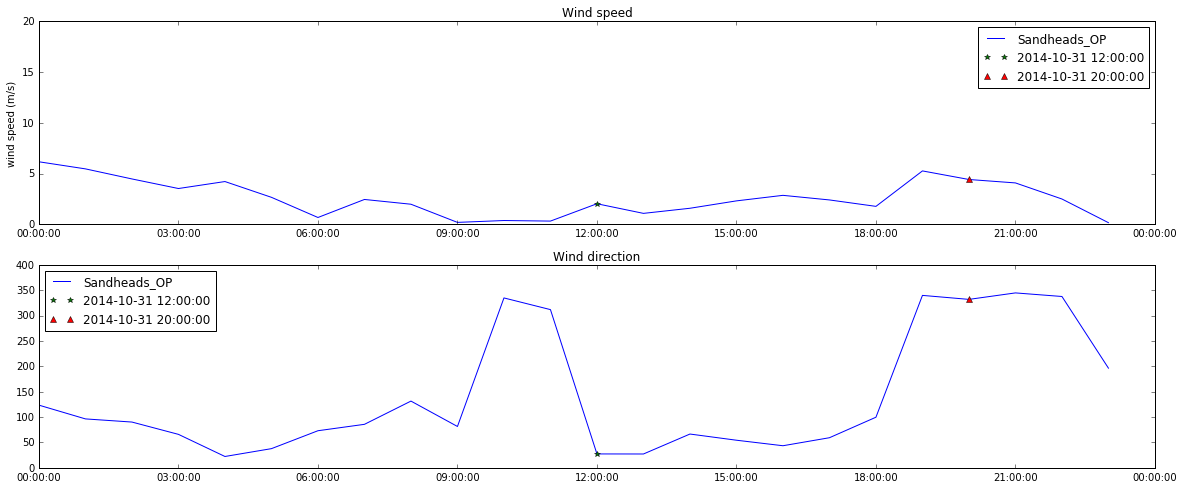

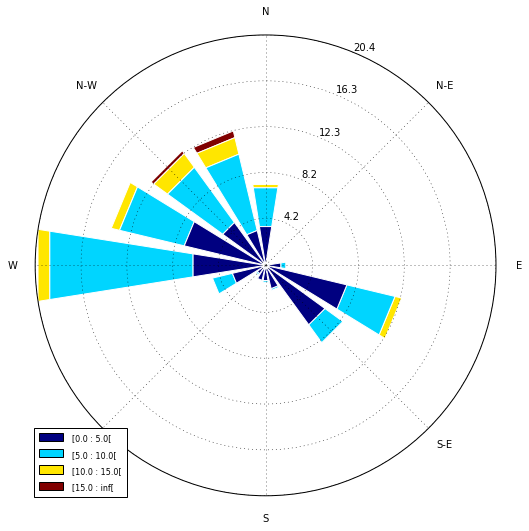

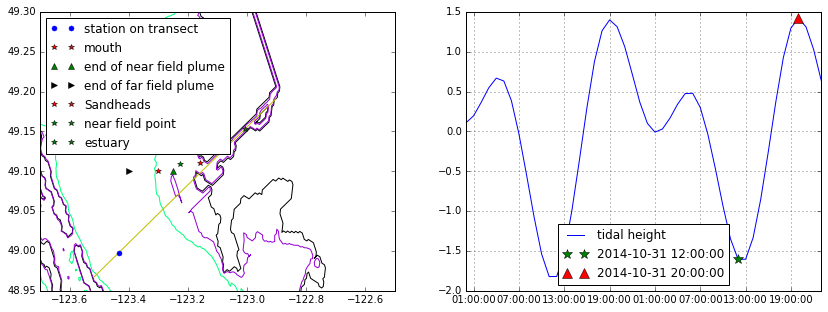

In [15]:
fig, axs = plt.subplots(1,2,figsize = (14,5))
ax = axs[0]
viz_tools.plot_coastline(ax, grid6, coords = 'map')
viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 5,color = 'DarkViolet')
viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 50,color = 'springgreen')
lon = all_T.variables['nav_lon']
lat = all_T.variables['nav_lat']
ax.plot(lon[36,4:123],lat[36,4:123],'y-') ## transect
ax.plot(lon[36,20],lat[36,20],'b.',markersize = 10,label ='station on transect')
ax.plot(-123.16, 49.11,'r*',label = 'mouth') ## (39,74)
ax.plot(-123.25, 49.1,'g^',label = 'end of near field plume') ## (43,59)
ax.plot(-123.4, 49.1,'k>',label = 'end of far field plume') ## (33,38)
ax.plot(-123.3,49.1,'r*',label = 'Sandheads')
ax.plot(lon[43,64],lat[43,64],'g*',label = 'near field point') ## (43,64)
ax.plot(lon[36,102],lat[36,102],'g*',label = 'estuary') ## (36,102)
ax.set_xlim([-123.7,-122.5])
ax.set_ylim([48.95,49.3])
ax.legend(loc  = 'best')
ax = axs[1]
run_low = datetime.datetime(2014,10,30)
run_up = datetime.datetime(2014,11,1)
run_label1 = datetime.datetime(2014,10,31,12)
run_label2 = datetime.datetime(2014,10,31,20)
low_ind,up_ind,lab_ind1,lab_ind2 = find_ind_tide(run_low,run_up,run_label1,run_label2)
ax.plot(ttide.time[low_ind:up_ind], ttide.pred_all[low_ind:up_ind],label = 'tidal height')
ax.plot(ttide.time[lab_ind1],ttide.pred_all[lab_ind1],'g*',markersize = 10,label = run_label1)
ax.plot(ttide.time[lab_ind2],ttide.pred_all[lab_ind2],'r^',markersize = 10,label = run_label2)
ax.legend(loc = 'best')
ax.grid('on')
X =Image(filename='/ocean/jieliu/research/meopar/surface current/wind_31oct14.png')
Y =Image(filename='/ocean/jieliu/research/meopar/surface current/windrose.png')
display(X,Y)

# R_mix plot

# No wind case

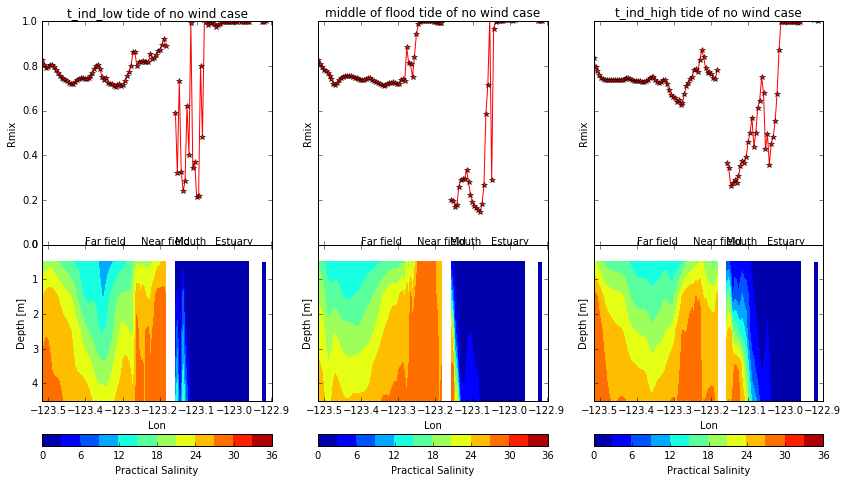

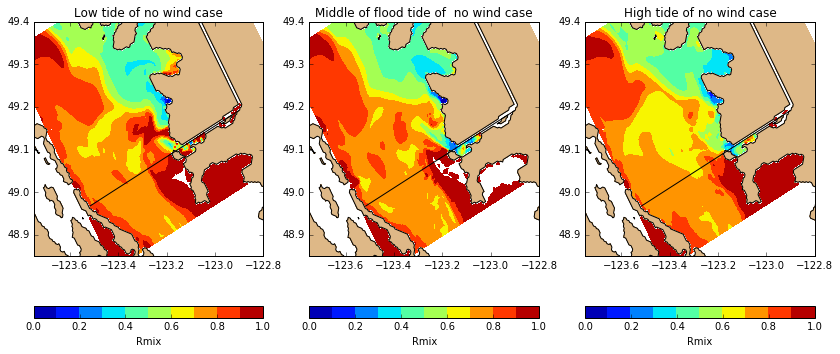

In [21]:
fig= RS.plot_salinity_estuary(nowind_T,sd,ed,4,np_mask,title = ' no wind case')
fig = RS.plot_spatial_Rmix(nowind_T,sd,ed,4, np_mask,title = ' no wind case')

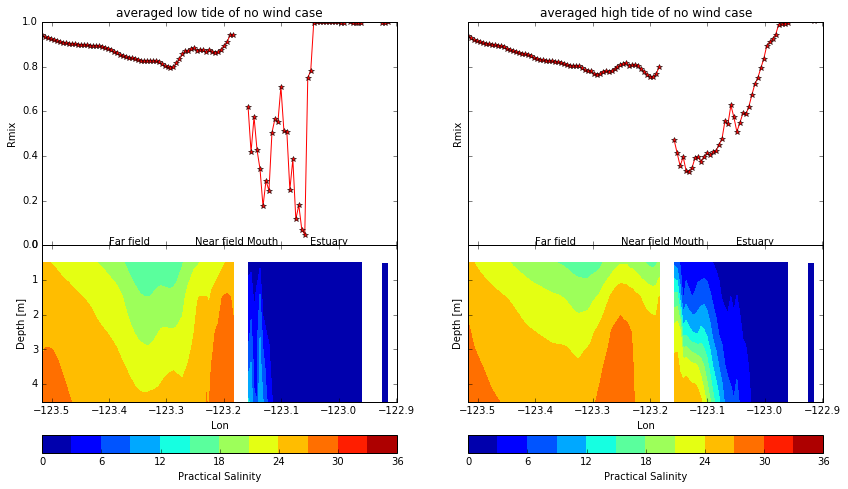

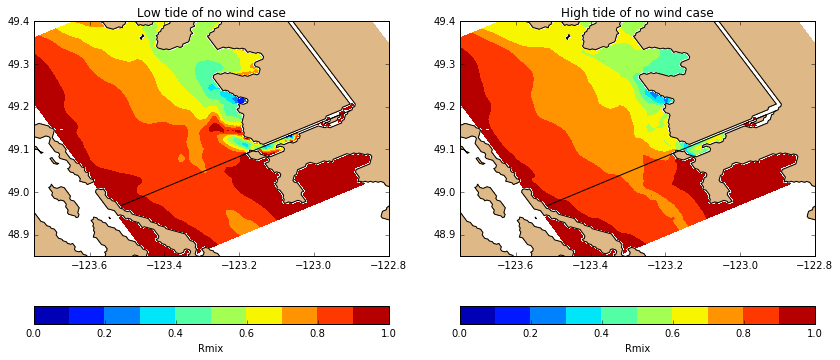

In [10]:
fig= RS.plot_salinity_estuary(nowind_T,sd,ed,4,np_mask,title = ' no wind case',string = 'ave')
fig = RS.plot_spatial_Rmix(nowind_T,sd,ed,4, np_mask,title = ' no wind case',string = 'ave')

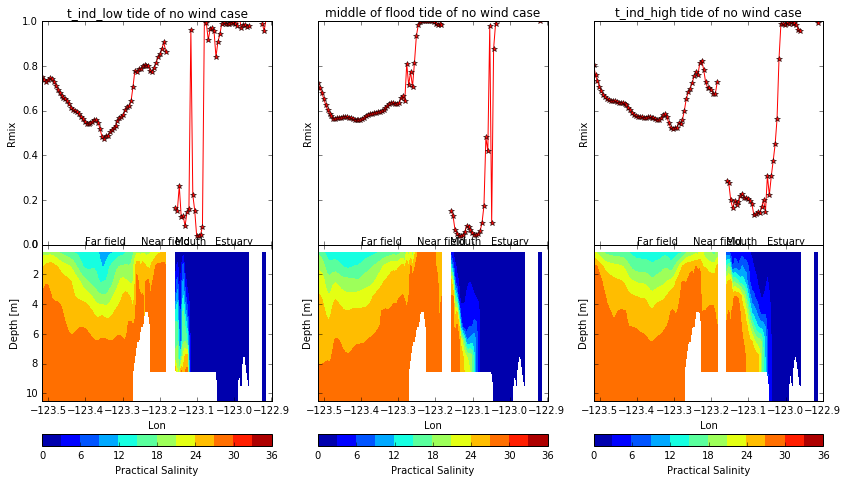

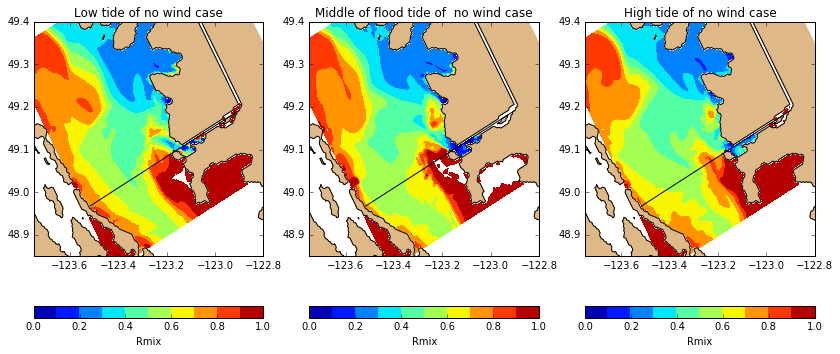

In [23]:
fig = RS.plot_salinity_estuary(nowind_T,sd,ed,10,np_mask,title = ' no wind case')
fig = RS.plot_spatial_Rmix(nowind_T,sd,ed,10, np_mask,title = ' no wind case')

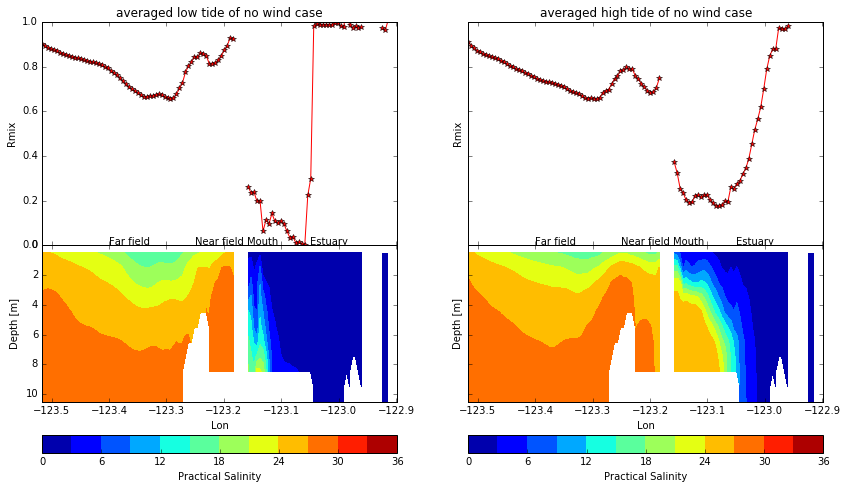

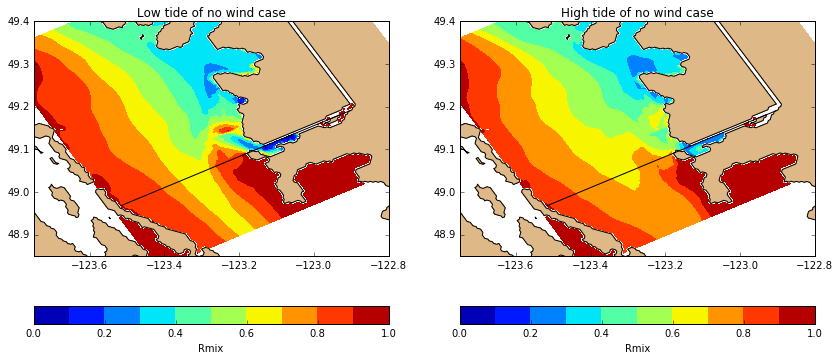

In [11]:
fig= RS.plot_salinity_estuary(nowind_T,sd,ed,10,np_mask,title = ' no wind case',string = 'ave')
fig = RS.plot_spatial_Rmix(nowind_T,sd,ed,10, np_mask,title = ' no wind case',string = 'ave')

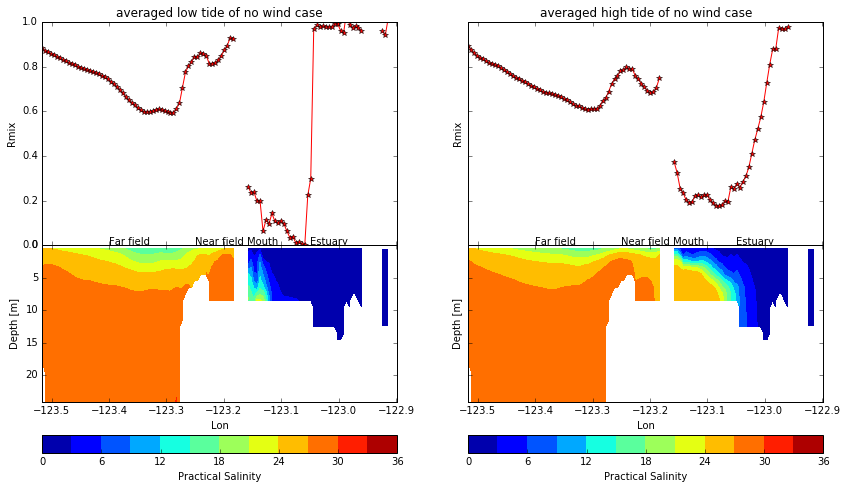

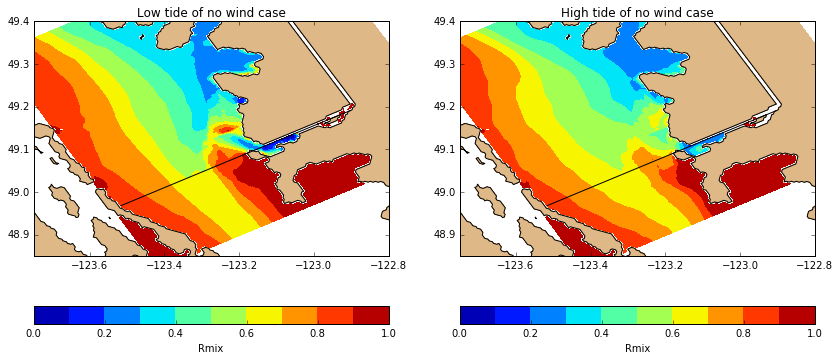

In [12]:
fig= RS.plot_salinity_estuary(nowind_T,sd,ed,20,np_mask,title = ' no wind case',string = 'ave')
fig = RS.plot_spatial_Rmix(nowind_T,sd,ed,20, np_mask,title = ' no wind case',string = 'ave')

# Combine all case

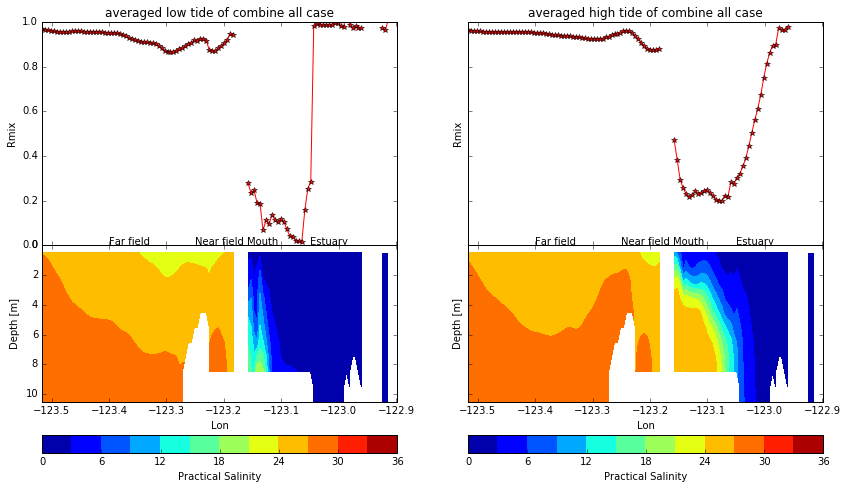

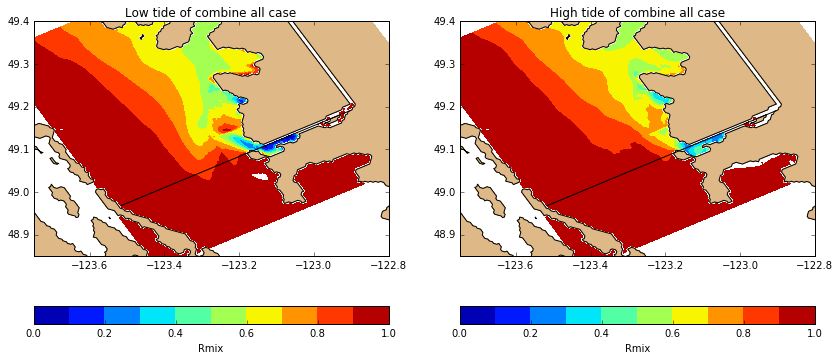

In [13]:
fig = RS.plot_salinity_estuary(all_T,sd,ed,10, np_mask,title = ' combine all case',string = 'ave')
fig = RS.plot_spatial_Rmix(all_T,sd,ed,10, np_mask,title = ' combine all case', string = 'ave')

# Currents at those specific times

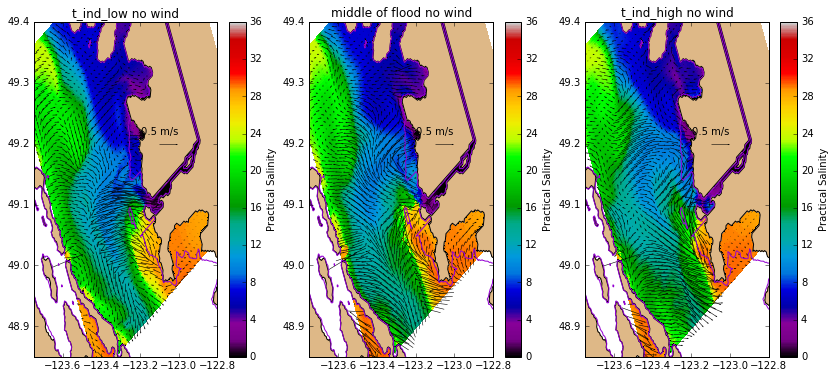

In [10]:
fig = RS.plot_spatial_circulation(nowind_T,nowind_U,nowind_V,0,'specific time',' no wind')

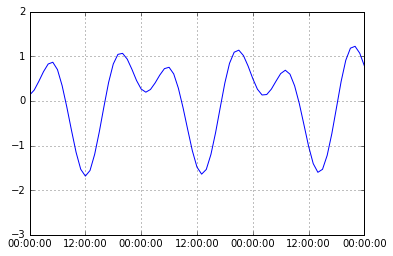

In [17]:
plt.plot(ttide.time,ttide.pred_all)
plt.xlim([datetime.datetime(2014,10,1),datetime.datetime(2014,10,4)])
plt.grid('on')